<a href="https://colab.research.google.com/github/super-Noam/NeuronNet/blob/master/summer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/google/jaxopt

  Cloning https://github.com/google/jaxopt to /tmp/pip-req-build-hctk7nm6
  Running command git clone -q https://github.com/google/jaxopt /tmp/pip-req-build-hctk7nm6
     |████████████████████████████████| 118 kB 4.9 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
  Created wheel for jaxopt: filename=jaxopt-0.0.1-py3-none-any.whl size=42747 sha256=9cb6eb52e7db438e7cf320a32ed3200299754ad0e9bda17011909d7f3a1cfd2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-dx5tfi2r/wheels/0c/1a/50/424ccbf29b323d1aa44474c7ccfdd30127d8d6fa97527794d7
Successfully built jaxopt


In [17]:
import jax
import torch
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from mpl_toolkits import mplot3d
from jaxopt import implicit_diff
from sklearn import datasets, model_selection

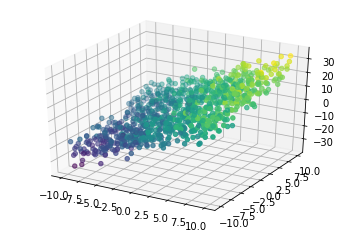

In [10]:
a = 2
b = .75
c = 0

X = 20*np.random.rand(1000,2)-10

n=5*np.random.normal(size=X.shape[0])
Y=a*X[:,0]+b*X[:,1]+c+n

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], Y, c=Y)

In [15]:
def ridge_objective(w, theta) :
  residual = jnp.dot(x, w) - y
  return (jnp.sum(residual ** 2) + theta * jnp.sum(w ** 2)) / 2

F = jax.grad(ridge_objective)

@implicit_diff.custom_root(F)
def ridge_solver(theta):
  XX = jnp.dot(X.T, X)
  XY = jnp.dot(X.T, Y)
  I = jnp.eye(X.shape[1])
  return jnp.linalg.solve(XX + theta * I, XY)

#print(jax.jacobian(ridge_solver)(2.))
print(ridge_solver(800.))
print(jax.jacobian(ridge_solver, argnums=1)(0.))

[1.9677967 0.7507661]


IndexError: ignored

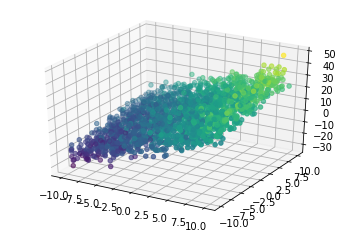

In [20]:
a = 2.
b = .75
c = 5.

X = 20*np.random.rand(2000,2)-10

n=5*np.random.normal(size=X.shape[0])
Y=a*X[:,0]+b*X[:,1]+c+n

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], Y, c=Y)

# Split data
(X_train, X_val,
 Y_train, Y_val) = model_selection.train_test_split(
                                                  X, Y,
                                                  test_size=0.33,
                                                  random_state=0)

In [22]:
theta = jnp.array([1., 2.])
beta = jnp.array([4.85, 2., .75])
learning_rate = .00001

"""
def regression_objective(beta, theta):    #f
  beta1 = jnp.array([beta[1], beta[2]])
  beta0 = beta[0]
  predictions = jnp.dot(X_train, beta1) + beta0 * jnp.ones_like(X_train[:, 0])
  return jnp.linalg.norm(predictions - Y_train)**2 + theta[1]*jnp.linalg.norm(beta1)**2 + theta[0]*jnp.abs(beta0)"""

def regression_objective(beta, theta):    #f
  beta1 = jnp.array([beta[1], beta[2]])
  beta0 = beta[0]
  predictions = jnp.dot(X_val, beta1) + beta0 * jnp.ones_like(X_val[:, 0])
  return jnp.linalg.norm(predictions - Y_val)**2 + theta[1]*jnp.linalg.norm(beta1)**2 + theta[0]*jnp.abs(beta0)

F = jax.grad(regression_objective)      #F

@implicit_diff.custom_root(F)
def regression_solver(beta, theta):     #x_star

  def loss(beta):
    beta1 = jnp.array([beta[1], beta[2]])
    beta0 = beta[0]
    predictions = jnp.dot(X_train, beta1) + beta0 * jnp.ones_like(X_train[:, 0])
    return jnp.linalg.norm(predictions - Y_train)**2 + theta[1]*jnp.linalg.norm(beta1)**2 + theta[0]*jnp.abs(beta0)

  for epoch in range(150):
    grads = jax.grad(loss)(beta)
    beta = [b - learning_rate * grad
              for b, grad in zip(beta, grads)]
    #if epoch%10 == 0 :
    #  print(epoch, beta)

  return beta

#this prints the jacobian of the solution of the regression solver x_star
#wrt the regularization parameters theta :
#print(jax.jacobian(regression_solver, argnums = 1)(beta, theta))

#gradient descent of the validation loss wrt theta :
for epoch in range(50) :
  jacobian = jax.jacobian(regression_solver, argnums = 1)(beta, theta)

0 [4.8533719163513185, 2.02190724609375, 0.7725534643554688]
10 [DeviceArray(4.8837695, dtype=float32), DeviceArray(2.0260773, dtype=float32), DeviceArray(0.7770101, dtype=float32)]
20 [DeviceArray(4.9069624, dtype=float32), DeviceArray(2.0261757, dtype=float32), DeviceArray(0.7770684, dtype=float32)]
30 [DeviceArray(4.9246416, dtype=float32), DeviceArray(2.026251, dtype=float32), DeviceArray(0.77711284, dtype=float32)]
40 [DeviceArray(4.938118, dtype=float32), DeviceArray(2.0263083, dtype=float32), DeviceArray(0.7771467, dtype=float32)]
50 [DeviceArray(4.948391, dtype=float32), DeviceArray(2.026352, dtype=float32), DeviceArray(0.77717257, dtype=float32)]
60 [DeviceArray(4.9562216, dtype=float32), DeviceArray(2.026385, dtype=float32), DeviceArray(0.77719223, dtype=float32)]
70 [DeviceArray(4.96219, dtype=float32), DeviceArray(2.0264106, dtype=float32), DeviceArray(0.77720726, dtype=float32)]
80 [DeviceArray(4.9667397, dtype=float32), DeviceArray(2.02643, dtype=float32), DeviceArray(0.7

array([2.  , 2.  , 0.75])